<a href="https://colab.research.google.com/github/rohankodavalla/Montreals-snowed-in-bus-stops/blob/main/snow_removal_transit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What are we doing?
1. Using the Snow removal csv and fing the "Average Bus Stop Snow Accessibility Ratings by Municipality; Best to Worst"

2. Heatmap of Montreal with boroughs, representing the demand for snow accessibility feedback at bus stops in Montreal based on the number of responses (response_count)

3. Heatmap of Montreal, filtering only low-rated stops (rating below 3), so that we can analyze density of bad locations

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import requests

# step 1: load montreal snow removal data
url = "https://blog.transitapp.com/wp-content/uploads/2024/01/2023_12_snow_neige_export.csv"
df = pd.read_csv(url)
print("Dataset Loaded: ", df.shape)
df.head()


Dataset Loaded:  (6528, 9)


,systeme_system,nom_name,stop_id,lat,long,moyen_average_score,total_reponses_responses,montreal_muni_nom_name,montreal_muni_type
0,STM,Senkus / Carrefour Angrignon,105093,45.447009,-73.620458,3.0,1,LaSalle,Arrondissement_borough
1,STM,Bourdeau / Lapierre,97445,45.434473,-73.603488,5.0,2,LaSalle,Arrondissement_borough
2,STM,Bishop-Power / Champlain,97443,45.428681,-73.607418,1.0,1,LaSalle,Arrondissement_borough
3,STM,Gagné / George,97442,45.425282,-73.608848,5.0,1,LaSalle,Arrondissement_borough
4,STM,Dollard / Salley,97439,45.425165,-73.623768,3.0,2,LaSalle,Arrondissement_borough


In [11]:
print(df.columns)


Index(['systeme_system', 'nom_name', 'stop_id', 'lat', 'long',
       'moyen_average_score', 'total_reponses_responses',
       'montreal_muni_nom_name', 'montreal_muni_type'],
      dtype='object')


In [12]:
# step 2: clean and rename columns
df.rename(columns={
    'lat': 'latitude',
    'long': 'longitude',
    'moyen_average_score': 'average_rating',
    'total_reponses_responses': 'response_count',
    'montreal_muni_nom_name': 'municipality'
}, inplace=True)

In [13]:
# drop rows with missing lat/long values
df.dropna(subset=['latitude', 'longitude', 'average_rating'], inplace=True)

In [14]:
# step 3: aggregate data - average ratings per municipality
ratings_summary = df.groupby('municipality')['average_rating'].mean().reset_index()
ratings_summary = ratings_summary.sort_values(by='average_rating')
### how to see what this rating summary means
ratings_summary.head()


,municipality,average_rating
17,Montréal-Est,2.807143
19,Montréal-Ouest,3.009091
25,Saint-Laurent,3.089299
11,LaSalle,3.152841
29,Ville-Marie,3.194429


# 1.**Using the Snow removal csv and finding the "Average Bus Stop Snow Accessibility Ratings by Municipality; Best to Worst"**




<ipython-input-15-149d81cf3c4a>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='municipality', x='average_rating', data=ratings_summary, palette='coolwarm')


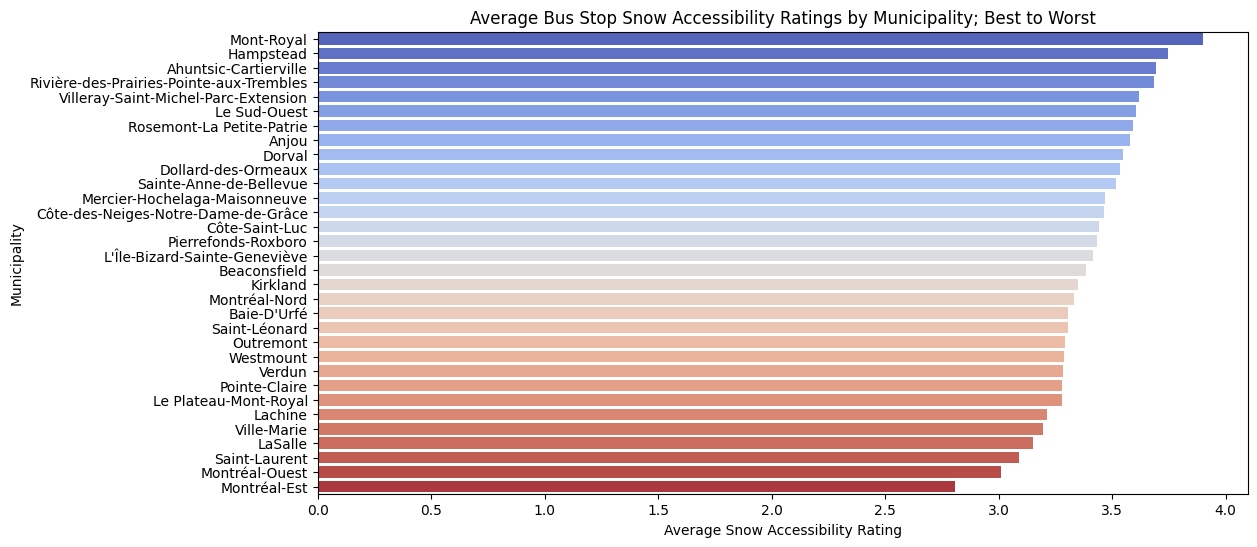

In [15]:
# step 4: visualization - bar plot for municipality ratings

ratings_summary = ratings_summary.sort_values(by='average_rating', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(y='municipality', x='average_rating', data=ratings_summary, palette='coolwarm')
plt.xlabel('Average Snow Accessibility Rating')
plt.ylabel('Municipality')
plt.title('Average Bus Stop Snow Accessibility Ratings by Municipality; Best to Worst')
plt.show()

# 2. **Heatmap of Montreal with boroughs, representing the demand for snow accessibility feedback at bus stops in Montreal based on the number of responses (response_count)**

In [27]:
import folium
from folium.plugins import HeatMap
import geopandas as gpd
import pandas as pd
from IPython.display import display

# load Montreal borough boundaries geojson
montreal_geojson = "https://donnees.montreal.ca/dataset/limites-administratives-agglomeration/resource/e18bfd07-edc8-4ce8-8a5a-3b617662a794/download"

# create a folium map centered in Montreal
map_center = [45.5017, -73.5673]  # Montreal coordinates
m = folium.Map(location=map_center, zoom_start=12)

# convert stop demand data into a list of [lat, lon, weight]
if 'latitude' in df.columns and 'longitude' in df.columns and 'response_count' in df.columns:
    bus_demand = df[['latitude', 'longitude', 'response_count']].values.tolist()

    # add heatMap (weight represents number of responses)
    HeatMap(bus_demand, min_opacity=0.4, max_opacity=0.9, radius=20).add_to(m)
else:
    print("Error: Missing required columns (latitude, longitude, response_count). Check dataset!")

# overlay borough boundaries
folium.GeoJson(
    montreal_geojson,
    name="Montreal Boroughs",
    style_function=lambda feature: {
        "fillColor": "transparent",
        "color": "black",
        "weight": 3.5,
        "dashArray": "5, 5"
    }
).add_to(m)

# add a layer control for toggling boroughs
folium.LayerControl().add_to(m)

# show map
display(m)


# 3. **Heatmap of Montreal, filtering only low-rated stops (rating below 3), so that we can analyze density of worst bus stop snow accessibility**

In [28]:
# step 5: create interactive heatmap of low-rated bus stops
map_center = [45.5017, -73.5673]  # Montreal center
m = folium.Map(location=map_center, zoom_start=12)

# filter only low-rated stops (rating below 3)
low_rated_stops = df[df['average_rating'] < 3][['latitude', 'longitude']].values.tolist()
HeatMap(low_rated_stops).add_to(m)

# save, download map to desktop
# m.save("bus_stop_snow_accessibility_map.html")

# add overlay borough boundaries
folium.GeoJson(
    montreal_geojson,
    name="Montreal Boroughs",
    style_function=lambda feature: {
        "fillColor": "transparent",
        "color": "black",
        "weight": 3.5,
        "dashArray": "5, 5"
    }
).add_to(m)
# show Insights
print("\nKey Insights:")
print("- Municipalities with lowest-rated snow accessibility are highlighted.")
#print("- Interactive heatmap of poorly rated stops is generated.")

from IPython.display import display
display(m)


Key Insights:
- Municipalities with lowest-rated snow accessibility are highlighted.


In [10]:
#download interactive map
#from google.colab import files
#files.download("bus_stop_snow_accessibility_map.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Further digging into this,

# IDEA-1  : drawing an analogy between Income of an neighbourhood vs Snow removal rating at busstop

# WHY > Income can serve as a proxy for how quickly a neighborhood gets services (i.e., snow removal), since wealthier areas might get more attention.

# HOW > Snow removal at a bus stop indirectly can mean that the particular street is cleared too!

------------------------------------------------------------------------

#IDEA-2 : High-priority zones (near hospitals, government offices) are likely to have better snow removal ratings; are they ?

In [66]:


import pandas as pd
import requests
from io import StringIO

# Try to download the file manually
url_snow = "https://blog.transitapp.com/wp-content/uploads/2024/01/2023_12_snow_neige_export.csv"
response = requests.get(url_snow)

# Check if the request was successful
if response.status_code == 200:
    # Read the content into a pandas DataFrame
    snow_data = StringIO(response.text)
    df_snow = pd.read_csv(snow_data)
    df_snow = df_snow.rename(columns={'lat': 'latitude', 'long': 'longitude'})
    print(df_snow.head())
else:
    print("Failed to download data. Status code:", response.status_code)

# Load the CMHC data (adjust the file path if necessary)
cmhc_url = "https://www03.cmhc-schl.gc.ca/hmip-pimh/en/TableMapChart/TableMatchingCriteria?GeographyType=MetropolitanMajorArea&GeographyId=1060&CategoryLevel1=Population%2C%20Households%20and%20Housing%20Stock&CategoryLevel2=Household%20Income&ColumnField=HouseholdIncomeRange&RowField=Neighbourhood&SearchTags%5B0%5D.Key=Households&SearchTags%5B0%5D.Value=Number&SearchTags%5B1%5D.Key=Statistics&SearchTags%5B1%5D.Value=AverageAndMedian"

# Load the CMHC data manually
cmhc_data = pd.read_csv(cmhc_url)
cmhc_data.columns = ['Neighbourhood', 'Average_Income_Before_Taxes', 'Median_Income_Before_Taxes', 'Average_Income_After_Taxes', 'Median_Income_After_Taxes']
cmhc_data = cmhc_data[['Neighbourhood', 'Median_Income_Before_Taxes', 'Average_Income_Before_Taxes']]  # Select relevant columns
cmhc_data.dropna(inplace=True)  # Remove missing values

print(cmhc_data.head())




Failed to download data. Status code: 403


ParserError: Error tokenizing data. C error: Expected 1 fields in line 7, saw 2


In [63]:
# Check the actual column names in the CMHC dataset
print(cmhc_data.columns)


Index(['Unnamed: 0', 'Average Household Income Before Taxes',
       'Median Household Income Before Taxes',
       'Average Household Income After Taxes',
       'Median Household Income After Taxes'],
      dtype='object')


In [62]:

# ===========================
# STEP 2: Merge Data
# ===========================

# Convert Snow Data to GeoDataFrame
gdf_snow = gpd.GeoDataFrame(df_snow, geometry=gpd.points_from_xy(df_snow.longitude, df_snow.latitude))

# Convert CMHC Data to GeoDataFrame (Assuming Predefined Montreal Neighborhood Boundaries)
# You need a shapefile of Montreal neighborhoods, replace 'montreal_shapefile.shp' with actual source
neighbourhoods = gpd.read_file("montreal_shapefile.shp")
neighbourhoods = neighbourhoods.merge(cmhc_data, on="Neighbourhood", how="left")

# Perform Spatial Join: Link Bus Stops to Income Data
merged_data = gpd.sjoin(gdf_snow, neighbourhoods, how="left", predicate="intersects")

# ===========================
# STEP 3: Visualize Data
# ===========================

# Scatterplot: Snow Incidents vs. Low-Income Riders
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=merged_data["snow_incidents"],
    y=merged_data["Low_Income_Households"],
    hue=merged_data["Neighbourhood"],
    size=merged_data["Median_Income"],
    palette="coolwarm"
)
plt.xlabel("Snow Incidents")
plt.ylabel("Low-Income Households")
plt.title("Impact of Snow Removal on Vulnerable Communities")
plt.show()

# ===========================
# STEP 4: Generate Heatmap
# ===========================

# Create Montreal Base Map
map_montreal = folium.Map(location=[45.5017, -73.5673], zoom_start=12)

# Add Heatmap Layer of Snowed-in Stops in Low-Income Areas
heat_data = merged_data[['latitude', 'longitude']].dropna().values.tolist()
HeatMap(heat_data).add_to(map_montreal)

# Display Interactive Map
map_montreal

DataSourceError: montreal_shapefile.shp: No such file or directory